In [6]:

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3

# Data Preparation
train_dir = "../../data/train"
validation_dir = "../../data/validation"

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

num_classes = train_generator.num_classes
    

Found 19001 images belonging to 4 classes.
Found 2427 images belonging to 4 classes.


In [7]:

def build_hybrid_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    resnet_base.trainable = False
    vgg_base.trainable = False
    inception_base.trainable = False

    input_tensor = Input(shape=(224, 224, 3))
    resnet_output = resnet_base(input_tensor, training=False)
    resnet_output = GlobalAveragePooling2D()(resnet_output)

    vgg_output = vgg_base(input_tensor, training=False)
    vgg_output = GlobalAveragePooling2D()(vgg_output)

    inception_output = inception_base(input_tensor, training=False)
    inception_output = GlobalAveragePooling2D()(inception_output)

    merged = concatenate([resnet_output, vgg_output, inception_output])
    x = Dense(512, activation='relu')(merged)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_hybrid_model(num_classes)
model.summary()
    

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_7[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 5, 5,      │ 21,802,784 │ input_layer_7[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ inception_v3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 4608)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  2,359,808 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      2,052 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,467,044 (238.29 MB)

 Trainable params: 2,361,860 (9.01 MB)

 Non-trainable params: 60,105,184 (229.28 MB)

In [8]:

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator, validation_data=validation_generator, epochs=10
)
    

Epoch 1/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3219s 5s/step - accuracy: 0.6396 - loss: 1.0025 - val_accuracy: 0.7239 - val_loss: 0.6897
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3193s 5s/step - accuracy: 0.7174 - loss: 0.6647 - val_accuracy: 0.7219 - val_loss: 0.6891
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3196s 5s/step - accuracy: 0.7381 - loss: 0.6282 - val_accuracy: 0.7412 - val_loss: 0.6251
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3193s 5s/step - accuracy: 0.7447 - loss: 0.6090 - val_accuracy: 0.7371 - val_loss: 0.6594
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3191s 5s/step - accuracy: 0.7552 - loss: 0.5789 - val_accuracy: 0.7606 - val_loss: 0.5901
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3195s 5s/step - accuracy: 0.7589 - loss: 0.5711 - val_accuracy: 0.7548 - val_loss: 0.5972
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3162s 5s/step - accuracy: 0.7703 - loss: 0.5576 - val_accuracy: 0.7734 - val_loss: 0.5592
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3189s 5s/step - accuracy: 0.7761 - loss: 0.5399 - 

In [9]:
model.save("../../models/larger_dataset_hybrid_modal.keras")

# Evaluate
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

76/76 ━━━━━━━━━━━━━━━━━━━━ 362s 5s/step - accuracy: 0.7750 - loss: 0.5599
Validation Accuracy: 0.78


Epoch 1/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3678s 6s/step - AUC: 0.9501 - accuracy: 0.7830 - loss: 0.5401 - val_AUC: 0.9501 - val_accuracy: 0.7849 - val_loss: 0.5422
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3700s 6s/step - AUC: 0.9637 - accuracy: 0.8201 - loss: 0.4567 - val_AUC: 0.9530 - val_accuracy: 0.7944 - val_loss: 0.5258
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3725s 6s/step - AUC: 0.9649 - accuracy: 0.8222 - loss: 0.4502 - val_AUC: 0.9556 - val_accuracy: 0.7981 - val_loss: 0.5104
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3639s 6s/step - AUC: 0.9682 - accuracy: 0.8314 - loss: 0.4281 - val_AUC: 0.9556 - val_accuracy: 0.8059 - val_loss: 0.5117
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3682s 6s/step - AUC: 0.9679 - accuracy: 0.8275 - loss: 0.4283 - val_AUC: 0.9577 - val_accuracy: 0.8088 - val_loss: 0.4999
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3508s 6s/step - AUC: 0.9689 - accuracy: 0.8330 - loss: 0.4223 - val_AUC: 0.9571 - val_accuracy: 0.8101 - val_loss: 0.5057
Epoch 7/10
594/594 ━━━━━━━━━

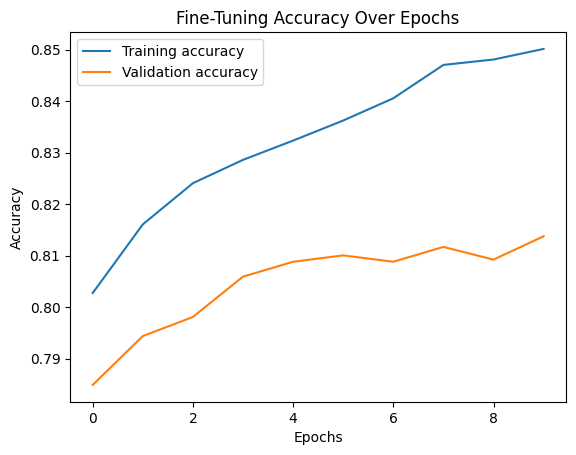

In [10]:
# Fine-Tuning the Hybrid Model
def fine_tune_model(model, train_generator, validation_generator, base_models, fine_tune_layers, learning_rate=1e-5, epochs=10):
    """
    Fine-tune the hybrid model by unfreezing specific layers of the base models.
    
    Parameters:
    - model: The hybrid model to fine-tune.
    - train_generator: Training data generator.
    - validation_generator: Validation data generator.
    - base_models: A list of base model instances [resnet_base, vgg_base, inception_base].
    - fine_tune_layers: A list of numbers specifying the number of layers to unfreeze for each base model.
    - learning_rate: Learning rate for fine-tuning.
    - epochs: Number of epochs for fine-tuning.
    """
    # Unfreeze the last few layers of each base model
    for base_model, layers_to_unfreeze in zip(base_models, fine_tune_layers):
        for layer in base_model.layers[-layers_to_unfreeze:]:
            layer.trainable = True

    # Recompile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

    # Fine-tune the model
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs)
    return history

# Specify the base models and the layers to fine-tune
resnet_base = model.get_layer("resnet50")  # Replace "resnet50" with the actual name of your ResNet base layer
vgg_base = model.get_layer("vgg16")        # Replace "vgg16" with the actual name of your VGG base layer
inception_base = model.get_layer("inception_v3")  # Replace "inception_v3" with the actual name of your Inception base layer

# Fine-tune layers: specify how many layers to unfreeze for each model
fine_tune_layers = [10, 4, 5]  # Example: last 10 layers of ResNet, 4 layers of VGG, 5 layers of Inception

# Run fine-tuning
fine_tune_history = fine_tune_model(
    model, train_generator, validation_generator,
    base_models=[resnet_base, vgg_base, inception_base],
    fine_tune_layers=fine_tune_layers,
    learning_rate=1e-5,
    epochs=10
)

# Plot Fine-Tuning Results
import matplotlib.pyplot as plt

def plot_fine_tuning_results(history, metric="accuracy"):
    plt.figure()
    plt.plot(history.history[metric], label=f"Training {metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
    plt.title(f"Fine-Tuning {metric.capitalize()} Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Plot results
plot_fine_tuning_results(fine_tune_history, metric="accuracy")
# plot_fine_tuning_results(fine_tune_history, metric="auc")


In [11]:
print(f"Training AUC: {fine_tune_history.history['accuracy'][-1]:.2f}")
print(f"Validation AUC: {fine_tune_history.history['val_accuracy'][-1]:.2f}")


Training AUC: 0.85
Validation AUC: 0.81
